In [1]:
import snapatac2 as snap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scanpy as sc
import polars as pl
import math
import anndata
snap.__version__

import seaborn as sns
import os

from adjustText import adjust_text
import pydeseq2
from pydeseq2 import preprocessing

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"    
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def convert_FDR_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "*****"
    elif pvalue <= 0.001:
        return "****"
    elif pvalue <= 0.01:
        return "***"
    elif pvalue <= 0.05:
        return "**"    
    elif pvalue <= 0.1:
        return "*"
    return "ns"

In [6]:
# Load the anndata
adata = sc.read_h5ad('rnaseq_anndata.h5ad')

In [8]:
adata.obs = adata.obs.copy()
adata.obs['Visit'] = adata.obs['Visit'].str.replace(' ','_')
adata.obs['Visit'] = adata.obs['Visit'].str.replace('Baseline_2', 'Vac2_Baseline')
adata.obs['Vaccine'] = adata.obs['Vaccine'].astype(str)
adata.obs['person_visit'] = adata.obs['person'].astype(str) + '-' + adata.obs['Visit'].astype(str)
adata.obs['vaccine_person'] = adata.obs['Vaccine'].astype(str) + '_' + adata.obs['person'].astype(str)
adata = adata[~( (adata.obs['Vaccine'] != "J&J") & (adata.obs['Visit'].isin(["Vac1_D7"])) )]
adata = adata[~( (adata.obs['Vaccine'] == "J&J") & (adata.obs['Visit'].isin(["Vac2_D7"])) )]
adata = adata[~(adata.obs['Visit'].isin(["Day70","Day180"])),:]
adata.obs['vaccine_visit'] = adata.obs['Vaccine'].astype(str) + '_' + adata.obs['Visit'].astype(str)
adata.obs['vaccine_person_visit'] = adata.obs['Vaccine'].astype(str) + '_' + adata.obs['person'].astype(str) + '_' + adata.obs['Visit'].astype(str)

/tmp/ipykernel_1096269/2251618424.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['vaccine_visit'] = adata.obs['Vaccine'].astype(str) + '_' + adata.obs['Visit'].astype(str)


In [10]:
adata = adata[adata.obs['celltypes'] == 'Monocyte CD14',:] # DEG for Monocyte CD14

# Deseq2

In [11]:
# Load Raw Read count anndata (Not Normalized)
rna = sc.read_10x_h5('filtered_feature_bc_matrix.h5')

/projects/ucar-lab/yyy/tools/conda/envs/snap_final/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/projects/ucar-lab/yyy/tools/conda/envs/snap_final/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
rna.var_names_make_unique()
cov_raw = rna[adata.obs_names,:] # Filter cells based on preprocessed anndata

In [13]:
cov_raw.obs.loc[:,'new_subset_annotations_2'] = adata.obs['new_subset_annotations_2']
cov_raw.obs.loc[:,'Vaccine'] = adata.obs['Vaccine']
cov_raw.obs.loc[:,'Visit'] = adata.obs['Visit']
cov_raw.obs.loc[:,'person'] = adata.obs['person']
cov_raw.obs.loc[:,'vaccine_visit'] = cov_raw.obs['Vaccine'].astype(str) + '_' + cov_raw.obs['Visit'].astype(str)
cov_raw.obs.loc[:,'vaccine_person'] = cov_raw.obs['Vaccine'].astype(str) + '_' + cov_raw.obs['person'].astype(str)
cov_raw.obs.loc[:,'vaccine_person_visit'] = cov_raw.obs['Vaccine'].astype(str) + '_' + \
        cov_raw.obs['person'].astype(str) + '_' + cov_raw.obs['Visit'].astype(str)

/projects/ucar-lab/yyy/tools/conda/envs/snap_final/lib/python3.12/site-packages/pandas/core/indexing.py:1761: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


In [14]:
min_pct=dict()
for i in cov_raw.obs['vaccine_visit'].unique():
    adata_group = cov_raw[cov_raw.obs["vaccine_visit"] == i].to_df()
    non_zero_counts_row = (adata_group != 0).sum(axis=0) / adata_group.shape[0]
    min_pct[i] = non_zero_counts_row

In [15]:
pass_genes = pd.DataFrame.from_dict(min_pct)[(pd.DataFrame.from_dict(min_pct) >= 0.01).any(axis=1)].index

In [16]:
pass_genes_ft = [i for i in pass_genes if 'RPS' not in i[:3] and 'MT-' 
                 not in i and 'LINC' not in i[:4] and 'RPL' not in i[:3]]

In [17]:
df = sc.get.obs_df(cov_raw, [*cov_raw.var_names, 'vaccine_person_visit'], use_raw=False)

In [19]:
dfm_rna = df.groupby(['vaccine_person_visit']).sum().reset_index().dropna()
dfm_rna = dfm_rna.set_index('vaccine_person_visit')
dfm_rna = dfm_rna.loc[:,pass_genes_ft]

In [20]:
metadata = pd.DataFrame(pd.DataFrame(dfm_rna.index).iloc[:,0].str.split('_', expand=True)[0] + '_' + \
            pd.DataFrame(dfm_rna.index).iloc[:,0].str.split('_', expand=True, n=2)[2])
metadata.index= dfm_rna.index

In [21]:
metadata.rename(columns={0:'Condition'}, inplace=True)
metadata['Group'] = metadata['Condition'].str.split('_',expand=True)[0].values

In [22]:
import pydeseq2
from pydeseq2 import preprocessing
import scipy
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [23]:
from pydeseq2.default_inference import DefaultInference
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(counts=dfm_rna,
                   metadata=metadata,
                   design_factors='Condition',
                   refit_cooks=True,
                   inference=inference,
                   )

/projects/ucar-lab/yyy/tools/conda/envs/snap_final/lib/python3.12/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [24]:
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 36.05 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 44.10 seconds.

Fitting LFCs...
... done in 19.25 seconds.

Calculating cook's distance...
... done in 0.07 seconds.

Replacing 0 outlier genes.



In [25]:
save_diff=dict()

pair_diff_set =[
                ['J&J-Vac1-D1','J&J-Baseline-1'],
                ['J&J-Vac1-D7','J&J-Baseline-1'],
                ['Moderna-Vac1-D1','Moderna-Baseline-1'],
                ['Moderna-Vac2-D1','Moderna-Baseline-1'],
                ['Moderna-Vac2-Baseline','Moderna-Baseline-1'],
                ['Moderna-Vac2-D7','Moderna-Baseline-1'],
                ['Pfizer-Vac1-D1','Pfizer-Baseline-1'],
                ['Pfizer-Vac2-Baseline','Pfizer-Baseline-1'],
                ['Pfizer-Vac2-D1','Pfizer-Baseline-1'],
                ['Pfizer-Vac2-D7','Pfizer-Baseline-1']
               ]

for pair_set in pair_diff_set:
        
    stat_res = DeseqStats(dds, inference=inference, contrast = ('Condition',pair_set[0],pair_set[1]))
    stat_res.summary()
    res = stat_res.results_df
    res = res[res.baseMean >= 10]
    res.loc[:,'Symbol'] = res.index

    save_diff[pair_set[0]] = res

Running Wald tests...
... done in 4.01 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition J&J-Vac1-D1 vs J&J-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AL627309.5   22.396382        0.180727  0.497928  0.362959  7.166357e-01   
NOC2L        20.842852        0.248883  0.317305  0.784366  4.328256e-01   
HES4          2.425554        3.228478  0.783049  4.122960  3.740354e-05   
ISG15       106.234784        3.897775  0.590394  6.601987  4.056827e-11   
AGRN          1.743846        1.367333  0.712835  1.918162  5.509049e-02   
...                ...             ...       ...       ...           ...   
KDM5D         8.856447       -0.587011  4.317326 -0.135966  8.918479e-01   
TTTY10        8.997689       -1.686270  3.619037 -0.465944  6.412554e-01   
EIF1AY       11.064398        0.184221  3.311332  0.055633  9.556338e-01   
AL592183.1   38.651941       -0.315228  0.429031 -0.734745  4.624947e-01   
AC240274.1    7.657820       -0.035962  0.424752 -0.084665  9.325274e-01   

         

... done in 4.01 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition J&J-Vac1-D7 vs J&J-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.5   22.396382       -0.310533  0.527360 -0.588844  0.555966  0.999966
NOC2L        20.842852        0.199026  0.346179  0.574923  0.565343  0.999966
HES4          2.425554       -0.809880  0.982544 -0.824268  0.409787  0.999966
ISG15       106.234784        0.136912  0.603317  0.226933  0.820476  0.999966
AGRN          1.743846       -1.837044  1.083552 -1.695391  0.090001  0.999966
...                ...             ...       ...       ...       ...       ...
KDM5D         8.856447       -0.233361  4.323663 -0.053973  0.956957  0.999966
TTTY10        8.997689       -0.096616  3.622016 -0.026675  0.978719  0.999966
EIF1AY       11.064398       -0.038044  3.321505 -0.011454  0.990861  0.999966
AL592183.1   38.651941        0.484523  0.438311  1.105431  0.268973  0.999966
AC240274.1    7.657820        0.652385  0.458253  1.4

... done in 4.00 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition Moderna-Vac1-D1 vs Moderna-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.5   22.396382        0.422223  0.381622  1.106390  0.268558  0.999517
NOC2L        20.842852        0.275909  0.269347  1.024363  0.305664  0.999517
HES4          2.425554        0.742820  0.814116  0.912426  0.361545  0.999517
ISG15       106.234784        0.672447  0.425456  1.580532  0.113985  0.999517
AGRN          1.743846        0.218606  0.855518  0.255525  0.798318  0.999517
...                ...             ...       ...       ...       ...       ...
KDM5D         8.856447        0.809351  3.070322  0.263605  0.792085  0.999517
TTTY10        8.997689       -0.432676  2.569149 -0.168412  0.866259  0.999517
EIF1AY       11.064398        0.174375  2.361116  0.073853  0.941128  0.999517
AL592183.1   38.651941       -0.358666  0.312121 -1.149123  0.250505  0.999517
AC240274.1    7.657820       -0.000285  0.378

... done in 3.97 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition Moderna-Vac2-D1 vs Moderna-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.5   22.396382        0.944388  0.377163  2.503923  0.012282  0.069999
NOC2L        20.842852        0.453624  0.263685  1.720325  0.085373  0.256478
HES4          2.425554        1.007678  0.791225  1.273566  0.202817  0.440516
ISG15       106.234784        2.066710  0.422846  4.887613  0.000001  0.000037
AGRN          1.743846        0.685851  0.801900  0.855283  0.392395  0.635400
...                ...             ...       ...       ...       ...       ...
KDM5D         8.856447        0.148877  3.078230  0.048365  0.961426  0.985182
TTTY10        8.997689       -1.225369  2.587845 -0.473509  0.635850  0.816860
EIF1AY       11.064398        0.584424  2.360870  0.247546  0.804486  0.911120
AL592183.1   38.651941       -0.493818  0.314460 -1.570369  0.116329  0.316053
AC240274.1    7.657820       -0.853846  0.406

... done in 4.01 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition Moderna-Vac2-Baseline vs Moderna-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.5   22.396382        0.051793  0.397274  0.130371  0.896273  0.999907
NOC2L        20.842852        0.259972  0.282712  0.919565  0.357800  0.999907
HES4          2.425554        0.183375  0.908686  0.201802  0.840071  0.999907
ISG15       106.234784        0.108843  0.430997  0.252539  0.800625  0.999907
AGRN          1.743846        0.875396  0.846814  1.033753  0.301252  0.999907
...                ...             ...       ...       ...       ...       ...
KDM5D         8.856447        0.654975  3.074635  0.213025  0.831307  0.999907
TTTY10        8.997689       -0.717797  2.580834 -0.278126  0.780915  0.999907
EIF1AY       11.064398        0.152333  2.366206  0.064379  0.948669  0.999907
AL592183.1   38.651941       -0.352762  0.318303 -1.108257  0.267751  0.999907
AC240274.1    7.657820        0.004901 

... done in 4.00 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition Moderna-Vac2-D7 vs Moderna-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.5   22.396382        0.282240  0.394356  0.715699  0.474177  0.999939
NOC2L        20.842852        0.336492  0.283326  1.187651  0.234971  0.999939
HES4          2.425554        0.126000  0.927447  0.135857  0.891935  0.999939
ISG15       106.234784       -0.335017  0.435720 -0.768881  0.441964  0.999939
AGRN          1.743846        0.536428  0.890647  0.602291  0.546981  0.999939
...                ...             ...       ...       ...       ...       ...
KDM5D         8.856447        0.452445  3.077351  0.147024  0.883113  0.999939
TTTY10        8.997689       -0.564941  2.579770 -0.218989  0.826659  0.999939
EIF1AY       11.064398        0.258722  2.366089  0.109346  0.912928  0.999939
AL592183.1   38.651941       -0.230930  0.317961 -0.726283  0.467665  0.999939
AC240274.1    7.657820       -0.236637  0.425

... done in 4.01 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition Pfizer-Vac1-D1 vs Pfizer-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.5   22.396382        0.165312  0.373373  0.442752  0.657945  0.999966
NOC2L        20.842852        0.046222  0.256566  0.180155  0.857031  0.999966
HES4          2.425554        1.069854  1.237842  0.864289  0.387429  0.999966
ISG15       106.234784        1.003653  0.430871  2.329356  0.019840  0.999966
AGRN          1.743846        0.249299  0.808698  0.308272  0.757875  0.999966
...                ...             ...       ...       ...       ...       ...
KDM5D         8.856447        0.030957  3.057799  0.010124  0.991923  0.999966
TTTY10        8.997689       -0.847639  2.548188 -0.332644  0.739403  0.999966
EIF1AY       11.064398       -0.645800  2.344215 -0.275487  0.782942  0.999966
AL592183.1   38.651941        0.089094  0.310161  0.287252  0.773919  0.999966
AC240274.1    7.657820        0.189443  0.32177

... done in 4.00 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition Pfizer-Vac2-Baseline vs Pfizer-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AL627309.5   22.396382       -0.287962  0.387785 -0.742583  0.457734  0.999953
NOC2L        20.842852        0.112783  0.263628  0.427813  0.668787  0.999953
HES4          2.425554        1.499694  1.231341  1.217936  0.223248  0.999953
ISG15       106.234784        0.538738  0.435640  1.236658  0.216214  0.999953
AGRN          1.743846       -0.213702  0.913985 -0.233813  0.815130  0.999953
...                ...             ...       ...       ...       ...       ...
KDM5D         8.856447        0.125892  3.058757  0.041158  0.967170  0.999953
TTTY10        8.997689       -0.288540  2.547231 -0.113276  0.909812  0.999953
EIF1AY       11.064398       -0.368499  2.344460 -0.157179  0.875104  0.999953
AL592183.1   38.651941       -0.246250  0.317783 -0.774898  0.438400  0.999953
AC240274.1    7.657820        0.109563  0

... done in 4.00 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index
Running Wald tests...


Log2 fold change & Wald test p-value: Condition Pfizer-Vac2-D1 vs Pfizer-Baseline-1
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AL627309.5   22.396382        0.388200  0.367700  1.055754  2.910805e-01   
NOC2L        20.842852        0.097969  0.248710  0.393909  6.936484e-01   
HES4          2.425554        2.931926  1.093208  2.681947  7.319505e-03   
ISG15       106.234784        2.246379  0.426752  5.263902  1.410299e-07   
AGRN          1.743846        0.899691  0.730922  1.230898  2.183610e-01   
...                ...             ...       ...       ...           ...   
KDM5D         8.856447        0.248356  3.056489  0.081255  9.352388e-01   
TTTY10        8.997689       -0.109649  2.545133 -0.043082  9.656364e-01   
EIF1AY       11.064398        0.368973  2.340437  0.157651  8.747316e-01   
AL592183.1   38.651941       -0.062030  0.309294 -0.200552  8.410485e-01   
AC240274.1    7.657820       -0.142238  0.319558 -0.445108  6.562417e-01   

   

... done in 3.98 seconds.

/tmp/ipykernel_1096269/1944878424.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:,'Symbol'] = res.index


In [26]:
cell_name=[]
upgenes=[]
downgenes=[]
for key, value in save_diff.items():
    cell_name.append(key)

    up_genes = sum((value['log2FoldChange'] > 0.5) & (value['pvalue'] < 0.05))
    down_genes = -sum((value['log2FoldChange'] < 0.5) & (value['pvalue'] < 0.05))
    
    upgenes.append(up_genes)
    downgenes.append(down_genes)

In [27]:
df_dap = pd.DataFrame({'Time':cell_name,'open':upgenes,'close':downgenes})

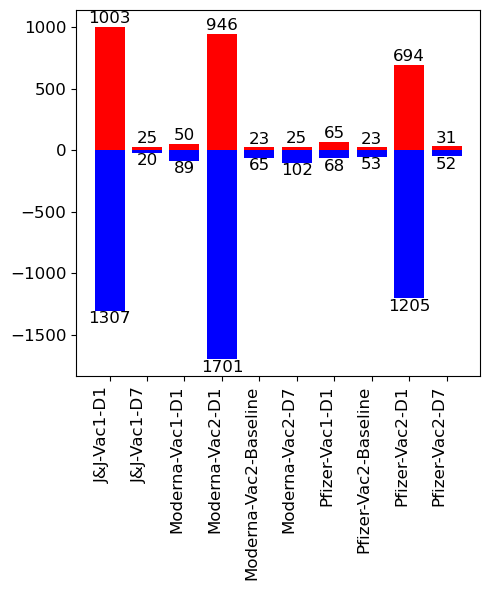

In [29]:
fig = plt.figure(figsize=[5,6])
ax = plt.subplot(111)
ax.bar(df_dap['Time'], df_dap['open'], width=0.8, color='r')
ax.bar(df_dap['Time'], df_dap['close'], width=0.8, color='b')
plt.xticks(rotation=90, ha='right',fontsize=12)
plt.yticks(fontsize=12)
for i in range(len(cell_name)):
    if (df_dap['open'][i] != 0) | (df_dap['close'][i] != 0):
        plt.text(df_dap['Time'][i], df_dap['open'][i] + 30, df_dap['open'][i], ha = 'center',fontsize=12)
        plt.text(df_dap['Time'][i], df_dap['close'][i] - 100, -df_dap['close'][i], ha = 'center', fontsize=12)
    elif (df_dap['open'][i] == 0) & (df_dap['close'][i] == 0):
        plt.text(df_dap['Time'][i], df_dap['close'][i], -df_dap['close'][i], ha = 'center', fontsize=12)

ax.set_xticks(np.arange(0, len(df_dap), 1))
ax.set_xticklabels(df_dap['Time'].values)

plt.tight_layout()

In [30]:
combined_df = pd.concat(save_diff.values(), ignore_index=True)

In [31]:
combined_df[(combined_df['pvalue'] < 0.05) & (combined_df['log2FoldChange'].abs() > 0.5)].to_excel('DEG_Results/CD14_Monocytes.xlsx')

In [34]:
# Gene List (Example: Type-I short gene list) # BloodGene3Module Interferon-modules  used in study
type1_list=['BATF2', 'CMPK2', 'CXCL10',	'CXCL11', 'DDX60', 'DHX58',	'EIF2AK2', 'HELZ2', 'IFI27']

<Figure size 580x600 with 0 Axes>

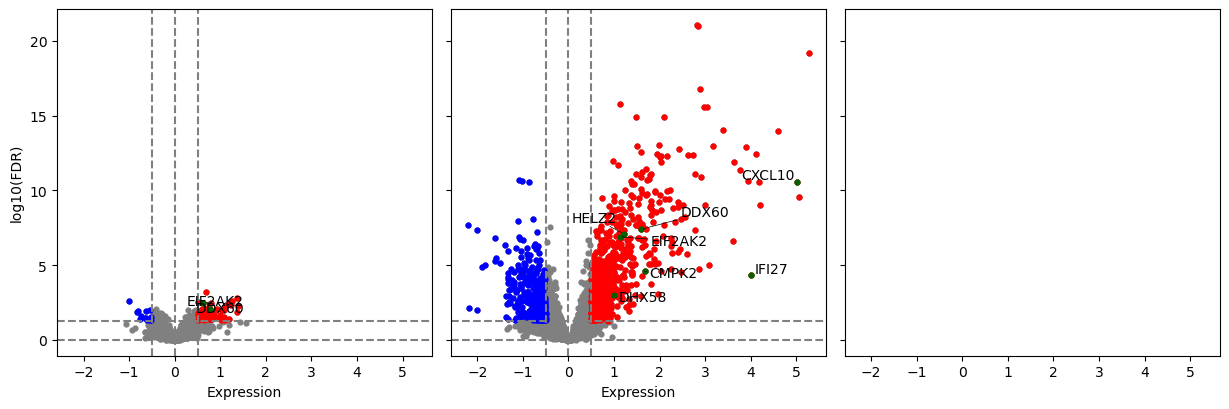

In [38]:
plt.figure(figsize=(5.8, 6))

thresh= 0.5
rightup_list=[]
lefttup_list=[]
# offset = 1e-8
offset = 0 
p_thresh = -np.log10(0.05 + offset)


# timepoints=['Moderna-Vac1-D1', 
#             'Moderna-Vac2-D1'
#            ]

# timepoints=['J&J-Vac1-D1', 
#             'J&J-Vac1-D7'
#            ]

timepoints=['Pfizer-Vac1-D1', 
            'Pfizer-Vac2-D1'
           ]

fig, ax = plt.subplots(1,3,figsize=[15,4.5],
                       sharey=True,
                       sharex=True
                       #gridspec_kw={'width_ratios': [1, 2,2]}
                      )

axes = ax.ravel()

k=0
for i in timepoints:

    plot_data=save_diff[i]
    
    log2f_label='log2FoldChange'
    pvaule_label='pvalue'
    
    mark_up = plot_data[(plot_data[log2f_label] > thresh) & (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    mark_down = plot_data[(plot_data[log2f_label] < -thresh) & (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    
    
    mark_pval = plot_data[(plot_data[log2f_label].abs() > thresh) & (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)].sort_values('stat', ascending=False)
    mark_gene_pval = mark_pval[mark_pval['Symbol'].isin(type1_list)][:10]
    
    rightup = plot_data[(plot_data[log2f_label] > thresh)& (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    rightdown = plot_data[(plot_data[log2f_label] > thresh) & (-np.log10(plot_data[pvaule_label] + offset) < p_thresh)]
    leftup = plot_data[(plot_data[log2f_label] < -thresh) & (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    leftdown = plot_data[(plot_data[log2f_label] < -thresh) & (-np.log10(plot_data[pvaule_label] + offset) < p_thresh)]
    remaining = plot_data[~plot_data.index.isin(list(leftup.index.values) + list(rightup.index.values))]
    
    mark_gene = rightup[rightup['Symbol'].isin(type1_list)]
    
    axes[k].scatter(x=plot_data[log2f_label],y=-np.log10(plot_data[pvaule_label] + offset),s=12,color="gray")
    axes[k].scatter(x=rightup[log2f_label],y=-np.log10(rightup[pvaule_label] + offset),s=12,color="red")
    axes[k].scatter(x=leftup[log2f_label],y=-np.log10(leftup[pvaule_label] + offset),s=12,color="blue")

    axes[k].scatter(x=mark_gene[log2f_label],y=-np.log10(
        mark_gene[pvaule_label] + offset),s=12,color="#006400")
    
    texts1=[]
    for r in mark_gene_pval.index[:]:
        t = axes[k].text(x=mark_gene_pval.loc[r,log2f_label],y=-np.log10(mark_gene_pval.loc[r,pvaule_label] + offset),s=r.split('.')[0])
        texts1.append(t)
    
    adjust_text(texts1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5),time_lim=6, force_text=(0.5, 0.5),expand=(1, 1),ax=axes[k])

    axes[k].axvline(0,color="grey",linestyle="--")
    axes[k].axhline(0,color="grey",linestyle="--")

    axes[k].axhline(p_thresh,color="grey",linestyle="--")

    axes[k].axvline(thresh,color="grey",linestyle="--")
    axes[k].axvline(-thresh,color="grey",linestyle="--")
    
    axes[0].set_ylabel("log10(FDR)")
    axes[k].set_xlabel("Expression")

    k += 1

plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Gene Enrichment

In [42]:
import gseapy as gp

In [ ]:
blood_gmt = gp.read_gmt(path="BloodGene3Module.gmt"). # BloodGene3Module Gene list

In [45]:
from gseapy import GSEA
vaccine_names=['J&J', 'Moderna', 'Pfizer']

timepoints=['Baseline_1','Vac1_D1', 'Vac1_D7', 'Vac2_Baseline','Vac2_D1', 'Vac2_D7']
# baseline_time='Baseline_1'

enr_res=dict()
enr=[]
for key, val in save_diff.items():
    temp_up=val[(val['pvalue'] < 0.05) & (val['log2FoldChange'] > 0.5)]
    temp_down=val[(val['pvalue'] < 0.05) & (val['log2FoldChange'] < 0.5)]

    print(key)
    enr2_up = gp.enrichr(
        gene_list = list(temp_up['Symbol'].unique()),
        gene_sets = [blood_gmt],
        organism='human',
        outdir=None, 
        )

    try:
        enr2_dw = gp.enrichr(
            gene_list = list(temp_down['Symbol'].unique()),
            gene_sets = blood_gmt,
            organism='human',
            )
        
    except:
        print([key,'failed dw'])


    enr2_up.results['UP_DW'] = key + '_UP'
    enr2_dw.results['UP_DW'] = key + '_DW'
    enr.append(enr2_up.results.sort_values('Adjusted P-value'))
    enr.append(enr2_dw.results.sort_values('Adjusted P-value'))
        
enr_res = pd.concat(enr)

J&J-Vac1-D1
J&J-Vac1-D7
Moderna-Vac1-D1
Moderna-Vac2-D1
Moderna-Vac2-Baseline
Moderna-Vac2-D7
Pfizer-Vac1-D1
Pfizer-Vac2-Baseline
Pfizer-Vac2-D1
Pfizer-Vac2-D7


In [46]:
enr_sig = enr_res[(enr_res['Adjusted P-value'] < 0.05) & (enr_res['Combined Score'] > 20)]
enr_sig.to_excel("gene_enrichment.xlsx", index=False)

In [47]:
enrich_path=[]
for i in enr_sig['UP_DW'].unique():
    enrich_path.append(enr_sig[enr_sig['UP_DW'] == i]['Term'].values)

In [48]:
unique_pathway = {item for sublist in enrich_path for item in sublist}

In [63]:
overlap_score = 90
overlap = []
for i in enr_sig['UP_DW'].unique():
    print([i,len(enr_res[enr_res['UP_DW'] == i])])
    temp = enr_res[(enr_res['UP_DW'] == i)]
    temp.loc[(temp['Adjusted P-value'] >= 0.05) & (temp['Combined Score'] < overlap_score),'Overlap']=None
    overlap.append(temp.set_index('Term').loc[[i for i in temp['Term'] if i in unique_pathway],:] \
                ['Overlap'].rename(i))

['J&J-Vac1-D1_UP', 288]
['Moderna-Vac1-D1_UP', 36]
['Moderna-Vac1-D1_DW', 62]
['Moderna-Vac2-D1_UP', 286]
['Moderna-Vac2-D1_DW', 340]
['Moderna-Vac2-Baseline_DW', 52]
['Pfizer-Vac1-D1_UP', 30]
['Pfizer-Vac1-D1_DW', 49]
['Pfizer-Vac2-D1_UP', 249]
['Pfizer-Vac2-D1_DW', 307]
['Pfizer-Vac2-D7_DW', 35]


In [64]:
overlap = pd.concat(overlap, axis=1).fillna(np.nan)
overlap = overlap.loc[[i for i in overlap.index if not 'TBD' in i],[i for i in overlap.columns if not 'DW' in i]]

In [65]:
overlap.insert(1, "J&J-Vac1-D7_UP", "")  # Insert at 2nd position (index 1)
overlap.insert(4, "Moderna-Vac2-D7_UP", "")  # Insert at 5th position (index 4)
overlap.insert(7, "Pfizer-Vac2-D7_UP", "")  # Insert at 5th position (index 4)

In [66]:
prep = []
for i in enr_sig['UP_DW'].unique():
    print([i,len(enr_res[enr_res['UP_DW'] == i])])
    temp = enr_res[(enr_res['UP_DW'] == i)]
    temp.loc[(temp['Adjusted P-value'] > 0.05) & (temp['Combined Score'] < overlap_score),'Adjusted P-value']=None
    prep.append(temp.set_index('Term').loc[[i for i in temp['Term'] if i in unique_pathway],:] \
                ['Adjusted P-value'].rename(i))

['J&J-Vac1-D1_UP', 288]
['Moderna-Vac1-D1_UP', 36]
['Moderna-Vac1-D1_DW', 62]
['Moderna-Vac2-D1_UP', 286]
['Moderna-Vac2-D1_DW', 340]
['Moderna-Vac2-Baseline_DW', 52]
['Pfizer-Vac1-D1_UP', 30]
['Pfizer-Vac1-D1_DW', 49]
['Pfizer-Vac2-D1_UP', 249]
['Pfizer-Vac2-D1_DW', 307]
['Pfizer-Vac2-D7_DW', 35]


In [67]:
prep_res = pd.concat(prep, axis=1).fillna(np.nan)
prep_res = prep_res.loc[[i for i in prep_res.index if not 'TBD' in i],[i for i in prep_res.columns if not 'DW' in i]]

In [68]:
prep_res.insert(1, "J&J-Vac1-D7_UP", np.nan)  # Insert at 2nd position (index 1)
prep_res.insert(4, "Moderna-Vac2-D7_UP", np.nan)  # Insert at 5th position (index 4)
prep_res.insert(7, "Pfizer-Vac2-D7_UP", np.nan)  # Insert at 5th position (index 4)

In [69]:
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list('bwr_alt', ([(0, '#C0C0C0') ,
                                                             (1,'#FF0000')]), N=256)

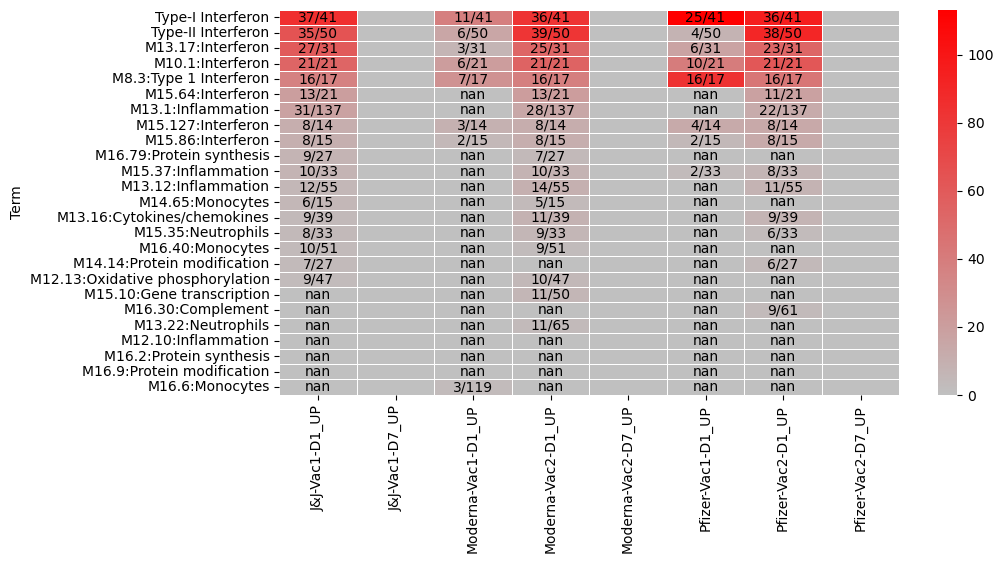

In [70]:
vmin=0
vmax=(-np.log(prep_res).fillna(0)).max().max()

fig, ax = plt.subplots(figsize=(10,5)) # Sample figsize in inches

g = sns.heatmap(
            -np.log(prep_res).fillna(0),
            cmap=custom_cmap,
            # center=0,
            ax=ax,
            linewidths=.5,
            # cmap=custom_cmap,
            vmin=vmin,
            vmax=vmax,
            annot=overlap,
            fmt="",
            annot_kws={"color": "black"}
            # square=True,
            # annot=True
            # robust=True
            # ax=axs[0],
            # yticklabels=False,
            # xticklabels=False,
            # cbar=None
            )

# plt.savefig('../figure/Monocyte_CD14/Monocyte_CD14_enrichment_overrep.eps')

In [71]:
norm_count = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs_names, columns=dds.var_names)

In [72]:
dfm_rna_zscore = scipy.stats.zscore(norm_count.T, axis=1)

In [73]:
group = ['Baseline_1', 'Vac1_D1', 'Vac1_D7','Vac2_Baseline', 'Vac2_D1', 'Vac2_D7']
vaccines = ['J&J','Moderna', 'Pfizer']
p_val=dict()
log2_diff=dict()
agg_dict=dict()

vaccine_cond=dict()
for vac_t in vaccines:
    score_mat_v2 = dfm_rna_zscore
    score_mat_v2 = score_mat_v2.loc[:,[i for i in score_mat_v2.columns if vac_t in i]]
    baseline = score_mat_v2.loc[:,[i for i in score_mat_v2.columns if group[0] in i]]
    
    for group_in in group:
        test_group = score_mat_v2.loc[:,[i for i in score_mat_v2.columns if group_in in i]]
            
        agg_dict[group_in] = test_group.mean(axis=1)
        
        score_mat_agg = pd.DataFrame.from_dict(agg_dict)
        score_mat_agg.index = score_mat_v2.index
        
    vaccine_cond[vac_t] = score_mat_agg

['J&J', 'Baseline_1', 1.6904744254594393e-20]
['J&J', 'Vac1_D7', 8.282332632398376e-20]
['Moderna', 'Baseline_1', 3.279164423251451e-08]
['Moderna', 'Vac2_Baseline', 7.046319901004891e-07]
['Moderna', 'Vac2_D1', 5.114769693401608e-07]
['Moderna', 'Vac2_D7', 4.008491937694384e-08]


/tmp/ipykernel_1096269/741517401.py:34: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  swarm = sns.swarmplot(
/tmp/ipykernel_1096269/741517401.py:53: UserWarning: 
The palette list has fewer values (1) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/tmp/ipykernel_1096269/741517401.py:34: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  swarm = sns.swarmplot(
/tmp/ipykernel_1096269/741517401.py:53: UserWarning: 
The palette list has fewer values (1) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/tmp/ipykernel_1096269/741517401.py:34: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  swarm = sns.swarmplot(


['Pfizer', 'Baseline_1', 2.2720557859104057e-07]
['Pfizer', 'Vac2_Baseline', 3.046746153969276e-05]
['Pfizer', 'Vac2_D1', 3.738555886210422e-08]
['Pfizer', 'Vac2_D7', 1.129493224332223e-06]


/tmp/ipykernel_1096269/741517401.py:53: UserWarning: 
The palette list has fewer values (1) than needed (17) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(
/projects/ucar-lab/yyy/tools/conda/envs/snap_final/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/projects/ucar-lab/yyy/tools/conda/envs/snap_final/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


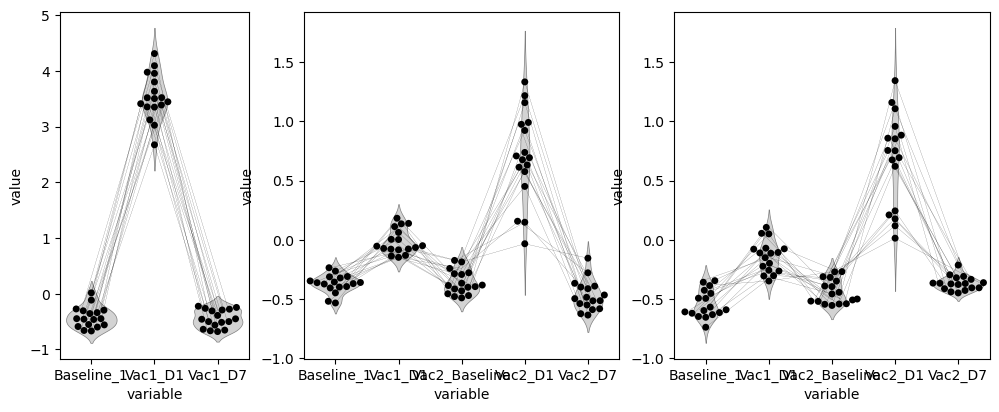

In [76]:
fig, ax = plt.subplots(1,3,figsize=[12,4.5], # 6,3.5
                       gridspec_kw={'width_ratios': [3, 5, 5]}
                       #sharey=True
                      )

axes = ax.ravel()

group = ['Baseline_1', 'Vac1_D1', 'Vac1_D7','Vac2_Baseline', 'Vac2_D1', 'Vac2_D7']
vaccines = ['J&J','Moderna', 'Pfizer']

select_pathway='M8.3:Type 1 Interferon'

k=0
for i in vaccines:

    score_mat_agg = vaccine_cond[i]
    df_melted = pd.melt(score_mat_agg.reset_index(), id_vars=["index"])
    df_melted = df_melted.loc[df_melted['index'].isin(set(blood_gmt[select_pathway])),:] 
    order_ = ['Baseline_1', 'Vac1_D1', 'Vac1_D7' ,'Vac2_Baseline', 'Vac2_D1', 'Vac2_D7']    
    df_melted["variable"] = pd.Categorical(df_melted["variable"], categories=order_, ordered=True)
    df_melted = df_melted.dropna()
    df_melted["variable"] = df_melted["variable"].cat.remove_unused_categories()
    df_melted.sort_values(['variable','value'], inplace=True)

    baseline = df_melted[df_melted['variable'] == 'Vac1_D1'].set_index('index')
    pvalues = dict()
    for varib in df_melted['variable'].unique():
        if 'Vac1_D1' not in varib:
            df_group = df_melted[df_melted['variable'] == varib].set_index('index').loc[baseline.index,:]
            stats, pval = scipy.stats.ttest_rel(list(df_group['value']), list(baseline['value']))
            pvalues[varib] = pval
            print([i,varib,pval])
        
    swarm = sns.swarmplot(
               x='variable', 
               y='value', 
               data=df_melted, 
               legend=False, 
               palette=['k'], 
               ax=axes[k]
             )

    combine_off = []
    collections = swarm.collections
    for col in collections:
        offsets = col.get_offsets()
        plot_data = pd.DataFrame(offsets, columns=['x', 'y'])
        plot_data = plot_data.sort_values('y')
        combine_off.append(plot_data)
    combine_off = pd.concat(combine_off).reset_index(drop=True)
    combine_off['sub'] = df_melted['index'].values

    sns.lineplot(
                x='x', 
                y='y', 
                data=combine_off, 
                hue='sub', 
                legend=False, 
                palette=['k'],
                markers=False, 
                linewidth=0.1,
                ax=axes[k]
                )
    
    sns.violinplot(
                data=df_melted, 
                x="variable", 
                y="value", 
                inner=None, 
                color="lightgray", 
                linewidth=0.5,
                ax=axes[k]
                )

    max_y=df_melted.value.max()        
    k+=1

axes[1].sharey(axes[2])

# TF Diffrential

In [78]:
# Read Chromvar_output file
chromvar = pd.read_csv('chromvar_adjusted.csv') 

In [80]:
gene_names_all = set(pd.DataFrame(chromvar.columns[1:])[0].str.split('.',expand=True)[0].values)

<Figure size 580x600 with 0 Axes>

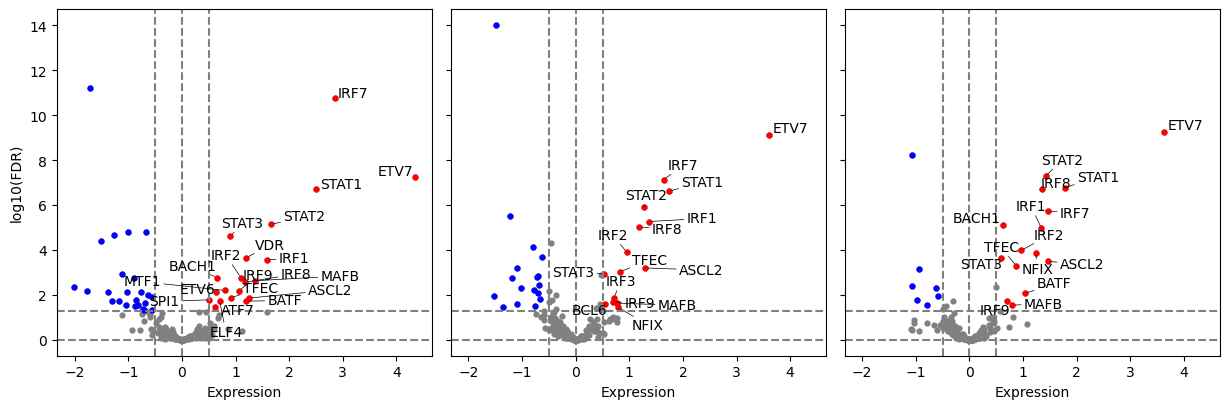

In [82]:
plt.figure(figsize=(5.8, 6))

thresh = 0.5
mark_value= 0.5
rightup_list=[]
lefttup_list=[]
# offset = 1e-8
offset = 0 
p_thresh = -np.log10(0.05 + offset)

timepoints=['J&J-Vac1-D1', 
            'Moderna-Vac2-D1',
            'Pfizer-Vac2-D1',
            
           ]

fig, ax = plt.subplots(1,3,figsize=[15,4.5],
                       sharey=True,
                       sharex=True
                       #gridspec_kw={'width_ratios': [1, 2,2]}
                      )

axes = ax.ravel()

k=0
for i in timepoints:

    plot_data=save_diff[i]
    
    log2f_label='log2FoldChange'
    pvaule_label='padj'

    plot_data = plot_data.loc[[i for i in plot_data.index if i in gene_names_all],:]
    
    mark_up = plot_data[(plot_data[log2f_label] > mark_value) & (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    mark_down = plot_data[(plot_data[log2f_label] < -mark_value) & (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    
    
    mark_pval = plot_data[(plot_data[log2f_label].abs() > thresh) & (-np.log10(plot_data[pvaule_label] + offset) > 1.5)].sort_values('stat', ascending=False)
    mark_gene_pval = mark_pval[mark_pval['Symbol'].isin(blood_gmt)][:10]

    
    rightup = plot_data[(plot_data[log2f_label] > thresh)& (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    rightdown = plot_data[(plot_data[log2f_label] > thresh) & (-np.log10(plot_data[pvaule_label] + offset) < p_thresh)]
    leftup = plot_data[(plot_data[log2f_label] < -thresh) & (-np.log10(plot_data[pvaule_label] + offset) > p_thresh)]
    leftdown = plot_data[(plot_data[log2f_label] < -thresh) & (-np.log10(plot_data[pvaule_label] + offset) < p_thresh)]
    remaining = plot_data[~plot_data.index.isin(list(leftup.index.values) + list(rightup.index.values))]
    
    mark_gene = rightup[rightup['Symbol'].isin(blood_gmt)]
    
    axes[k].scatter(x=plot_data[log2f_label],y=-np.log10(plot_data[pvaule_label] + offset),s=12,color="gray")
    axes[k].scatter(x=rightup[log2f_label],y=-np.log10(rightup[pvaule_label] + offset),s=12,color="red")
    axes[k].scatter(x=leftup[log2f_label],y=-np.log10(leftup[pvaule_label] + offset),s=12,color="blue")

    texts1=[]
    texts2=[]
    for r in mark_up.index[:]:
        t = axes[k].text(x=mark_up.loc[r,log2f_label],y=-np.log10(mark_up.loc[r,pvaule_label] + offset)
                         ,s=r.split('.')[0])
        texts1.append(t)

    adjust_text(texts1, arrowprops=dict(arrowstyle="-", color='k', lw=0.5),time_lim=6, force_text=(0.5, 0.5),expand=(1, 1),ax=axes[k])
    adjust_text(texts2, arrowprops=dict(arrowstyle="-", color='k', lw=0.5),time_lim=6, force_text=(0.5, 0.5),expand=(1, 1),ax=axes[k])
    
    axes[k].axvline(0,color="grey",linestyle="--")
    axes[k].axhline(0,color="grey",linestyle="--")

    axes[k].axhline(p_thresh,color="grey",linestyle="--")

    axes[k].axvline(thresh,color="grey",linestyle="--")
    axes[k].axvline(-thresh,color="grey",linestyle="--")
    
    axes[0].set_ylabel("log10(FDR)")
    axes[k].set_xlabel("Expression")

    k += 1

plt.subplots_adjust(wspace=0.05, hspace=0.1)